[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7 2 1 0]
[4 0 7

KeyboardInterrupt: 

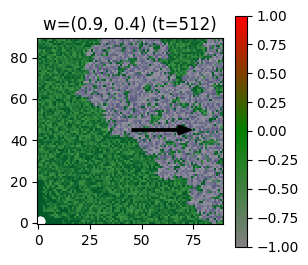

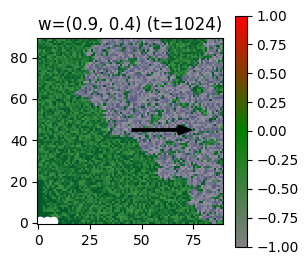

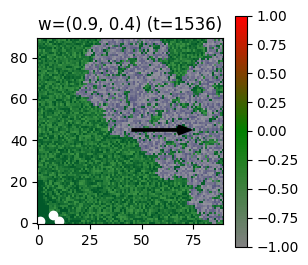

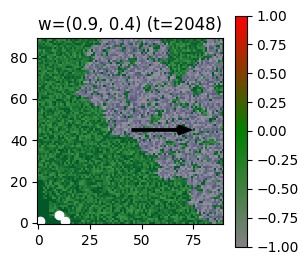

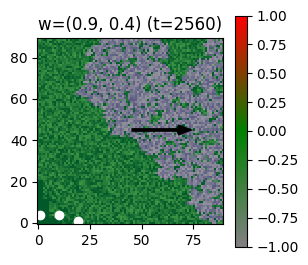

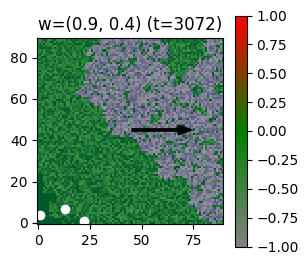

In [9]:
import os 
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical
import time
import tqdm

from PPO_Agent_Misc.PPOContinuous import Agent as ContPPO
from Simulation import FireMapEnv
from odds_and_ends.data_processing import process_RL_outputs, process_env_for_agent

# HYPERPARAMETERS
EPOCHS = 25
NUM_MINIBATCHES = 32
MINIBATCH = 16
EPISODES = 100
TS_PER_ITER = 2000

# Continuous Parameters
action_min = T.tensor((0.0, -1.0))
action_max = T.tensor((1.0, 1.0))

PPO_Agent = ContPPO(n_actions=6, c1=1.0, c2=0.5, input_dims=7200, action_min=action_min, action_max=action_max, 
                    gamma=0.99, gae_lambda=0.95, policy_clip=0.2, batch_size=MINIBATCH, 
                    buffer_size=MINIBATCH*NUM_MINIBATCHES, n_epochs=EPISODES, LR=1e-3, annealing=False)

env = FireMapEnv()
env.reset()

actions = np.reshape(np.random.randint(0, 45/3, 6), (3,2))
obs, rewards, dones, info = env.step(actions)

full_episode_loss = []
avg_policy_loss = []
avg_crit_loss = []
episode_max_ratio = []
ep_mean_rewards = []

obs = T.tensor(obs).float().to(PPO_Agent.device)
obs = process_env_for_agent(obs)
obs = T.flatten(obs)

env.reset()
for _ in range(EPISODES):
    # Step one, get some sort of training running. 
    for _ in range(TS_PER_ITER):
        # Set prev observation
        prev_obs = obs.clone()
        
        # Get actions from the agent
        actions, logprob, mean, prev_vf = PPO_Agent.get_action_and_vf(prev_obs)
        
        # Process raw actions into the environment 
        processed_actions = process_RL_outputs(actions.numpy())
        obs, rewards, dones, _ = env.step(processed_actions)
        obs = T.tensor(obs).to(PPO_Agent.device)
        obs = process_env_for_agent(obs)
        obs = T.flatten(obs).float()  

        # Get value of obs and store in agent
        next_vf = PPO_Agent.critic.forward(obs)
        next_vf = next_vf.detach()
        advantage = PPO_Agent.get_gae(rewards, prev_vf, next_vf)
        PPO_Agent.memory.store_memory(prev_obs, T.tensor(actions), logprob, advantage, prev_vf, rewards, dones)

        # Learning loop
        if len(PPO_Agent.memory.states) >= NUM_MINIBATCHES*MINIBATCH:
            for _ in range(NUM_MINIBATCHES):
                print("REWARDS ", PPO_Agent.memory.rewards)
                rewards = T.tensor(PPO_Agent.memory.rewards, dtype=T.float32)
                rew_mean = rewards.mean()
                rew_std = rewards.std()
                e_policy_loss, e_crit_loss, loss = PPO_Agent.learn(rew_mean, rew_std)

            env.render()

        PPO_Agent.c2 *= 0.95
        PPO_Agent.actor.var *= 0.95


In [9]:

device = T.device("cuda" if T.cuda.is_available() else "cpu")

class ActorModel(nn.Module):
    '''
        A continuous actionspace forces us to create some sort of distribution
        on the range of values on our actionspace. We force a normal distribution.
        Functionally what this means is our mean and var values are parameters 
        that change with training, so we have to create some sort of basis for this.
        
        Variational Autoencoders split a layer at the same depth to account for 
        this exact same thing. The code will look similar.

    '''
    def __init__(self, input_shape, n_actions, 
                 min_tens = T.tensor((-1, 1)), max_tens = T.tensor((-1, 1))):
        super(ActorModel, self).__init__()

        # base model
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=0, stride=2).to(device)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=0, stride=2).to(device)
        self.flatten_layer = nn.Flatten()
        self.fc1 = nn.Linear(in_features=1568, out_features=64).to(device)
        self.fc2 = nn.Linear(in_features=64, out_features=64).to(device)

        # distributions
        self.mean = nn.Linear(in_features=64, out_features=n_actions).to(device)

        # Constant variance
        self.var = T.diag(T.ones(n_actions)).to(device)*20

        # misc
        self.min_tens = min_tens
        self.max_tens = max_tens

    def forward(self, x):
        ''' We create a class that computes the distribution of our actions. '''

        # base computation
        x = F.relu(self.conv2(x)).to(device)
        x = self.flatten_layer(x)
        x = F.relu(self.fc1(x)).to(device)
        x = F.relu(self.fc2(x)).to(device)

        # split
        # we note the mean value goes through a tanh as it corresponds with the 
        # lunar lander task at hand. Specifically, we have a output which ranges from (-1,1)
        mean = F.relu(self.mean(x)).to(device)

        return mean
    
test = ActorModel(4, 5)
test.forward(obs)

    

tensor([[0.0022, 0.0000, 0.1405, 0.0790, 0.0730]], grad_fn=<ReluBackward0>)